In [1]:
import time
import copy
from IPython.display import Markdown, display, Video
from io import BytesIO
import os

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import imageio.v2 as imageio

import tempfile

from kmeans import Kmeans, kmeans_loss_function, assign_data_to_centroids
from kmeans_plotting import Plot2DKmeans
%matplotlib inline

# Clustering

Clustering is refered to the set of techniques which allows to automatically group data into what are called clusters. There are many ways of implementing this process. From techniques that fix a maximum number of clusters, others that learn hiearchical cluster, to others that can learn the number of clusters automatically. 

Clustering is also grouped under a set of algorithms known by unsupervised learning, although I do not like this taxonomy. Also, many algorithms are not well known for being used as clustering algorithms (such as mixture models) but we can obtain clusters from its construction. 

Example of algorithms that perform clustering includes Kmeans, HDBSCAN and Linear and Non-Linear Mixture Models and their infinite generalization through Dirichlet processes. There might be plenty more of them.

This assesment covers Kmeans.

# Kmeans: summary

The Kmeans is an algorithm which assigns data into clusters, based on computing a distance, with a predefinied number of clusters, which are then learnt automatically.

While it has a connection with Probabilistic Machine Learning (more precisely, it is a degenerated version of a Gaussian Mixture Model fitted through Maximum Log-Likelihood) the usual more intuitive design and description of the algorithm does not have a direct and clear connection with any of the usual mathematical probabilistic tools, in contrast with linear or logistic regression.

However, one can arrive at the algorithm and show that is just the Expectation Maximization algorithm assuming a Gaussian mixture model where the variances are not learnt and set to equal values, but it is not so direct. Another way of arriving at the algorithm is by the optimization of a loss function, which due to the optimization variables being involved (some of them being discrete) requires a coordinate descent optimization procedure. Up to my knowledge, this loss function does not have a probabilistic interpretation, in contrast to the approach that starts from a Gaussian Mixture Model. I would also need to check whether both approaches lead to the same optimization function, which I think it doesnt.

Since the loss function of the algorithm is non-convex there are many local minimas at which we can arrive. We will see that in fact initialization is a very important step in this algorithm.

The loss function targeted through this model is to minimize the within cluster variance, defined by:

\begin{split}
L(c,\mu,x) = \sum^K_{k=1}\sum_{n=1}^N r_{nk}\mid\mid x_n - \mu_k \mid\mid^2
\end{split}

where $r_{nk}$ is an indicator variable such that:

\begin{split}
r_{nk} = \begin{cases}
1, c_n = k\\
0, c_n \neq k
\end{cases}
\end{split}

Note that here we have $K$ continous variables $\mu_k \in \mathbb{R}^d$ and $N$ discrete variables $c_n \in \mathbb{N}$.

Optimizing this loss function is done through coordinate descent which results on the following algorithm:

* 1.  Initialization. Select the number of centroids to obtain and initialize them to any value. This could be done by selecting random points from the dataset, by selecting random point from the space of points, or advanced techniques such as the kmeans++ algorithm.

After initialization iterate the following steps:

* 2. Assign each datapoint to its closest centroid wrt some norm. The $L_2$ norm is usually used and is the one which connects with Gaussian Mixture Model.
* 3. Recompute centroids by the sample mean of the datapoints assigned to each of the clusters.

Assume we have $N$ datapoints, with $K$ clusters $S=\{S_1,\dots,S_K\}$. Each point is denoted by $x_n \in \mathbb{R}^d$, each cluster centroid by $\mu_k$ and $c_n$ denotes the cluster being assigned to each $x_n$. Denote by $\mu = \{\mu_1,\mu_2,\dots,\mu_K\}$ and $c = \{c_1,c_2,\dots,c_n\}$.


Mathematically we have:

* step 2:

\begin{split}
c_n = \underset{k}{\text{argmin}}\mid\mid x_n - \mu_k \mid\mid^2
\end{split}

* step 3: For each cluster $c$:

\begin{split}
\mu_k = \frac{1}{\mid S_k \mid}\sum_{x_i \in S_k} x_i
\end{split}

## Dataset

Create a dataset randomly to experiment with this assignment. Generate a total of $100$ sample points. You can sample these points randomly from some distribution, for example a Gaussian. Another option is to sample it from a $3$ Gaussian mixture model to generate separate clusers.

Sampling from a mixture model can be done through ancestral sampling by first drawing a cluster randomly from the probability of the clusters $p(c)$ and then sampling from the conditional distributions of the data given the cluster $p(x\mid c)$. Since this is a Gaussian mixture model we have $p(x\mid c)$ being a Gaussian distribution. Since the clusters are discrete random variables we can use a categorical variable to model this clusters, with three categories all of them being equally probable.

A good starting point is to assume:

\begin{split}
p(c) &= \text{Cat}(c \mid p=(0.33, 0.33, 0.34))\\
p(x\mid c) &= \mathcal{N}(x \mid, 0, 0.05 \cdot I )
\end{split}


**Task:** Draw 100 points and show them in to a 2-dimensional plot. This means that the Gaussian distribution being used are multivariate Gaussian distributions with $d=2$. Each of them will be parameterized with a vector mean and a covariance matris. Use a diagonal covariance matrix with variance being $0.05$, which is given by $0, 0.05 \cdot I$.

Plot the data using matplotlib.

Remember to shuffle the data after its creation, to improve the random initialization we will be doing later. This can be done through the following code:

```python
## shuffle data assuming X is a matrix where each row is a datapoint and columns represent data dimensions.
for i in range(10):
    np.random.shuffle(X)
```

To diagnose the follow up implementation seed the data generation using a seed of $1$, so that each time you run the cell the exact same dataset is generated. This can be done through:

```
np.random.seed(1)
```

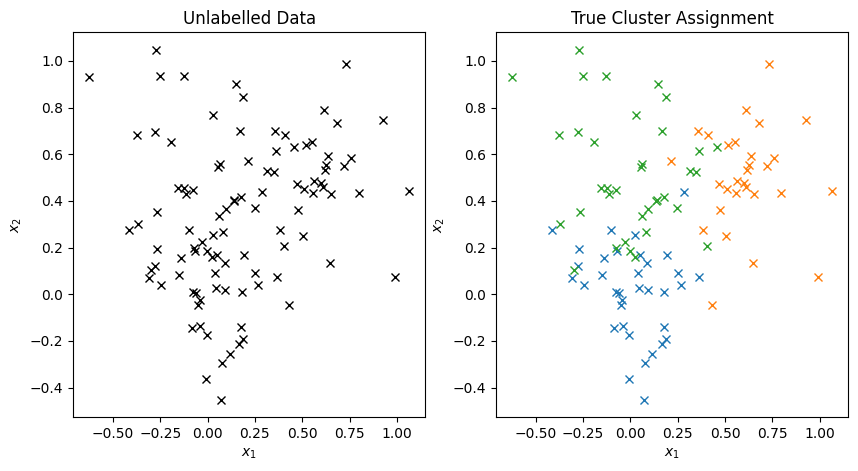

In [2]:
np.random.seed(1)

N_points = 100

## probability p(c)
p = [0.33,0.33,0.34]
c = [0,1,2]

## probability p(x|c)
p_xc = {
    'c_0' : {
        'mu' : np.array([0,0]),
        'cov' : 0.05*np.eye(2),
        },
    'c_1' : {
        'mu' : np.array([0.5,0.5]),
        'cov' : 0.05*np.eye(2),
        },
    'c_2' : {
        'mu' : np.array([0,0.5]),
        'cov' : 0.05*np.eye(2),
        }   
}

## sample cluster assignments
cluster = np.random.choice(c, size=N_points, p=p)

## 
X = np.zeros((N_points,2), dtype = np.float32)
counter = 0
X_clust = {}
for _c in c:
    num_c = np.sum(cluster==_c)
    
    mu  = p_xc[f'c_{_c}']['mu']
    cov = p_xc[f'c_{_c}']['cov']
    
    _x = np.random.multivariate_normal(mean=mu, cov=cov, size = num_c)
    X[counter:counter + num_c] = _x
    
    X_clust[_c] = _x
    
    counter += num_c

fig, (ax1,ax2) = plt.subplots(1,2, figsize = (10,5))
ax1.plot(X[:,0],X[:,1], 'x', color = 'k')
ax1.set_xlabel(r"$x_1$")
ax1.set_ylabel(r"$x_2$")
ax1.set_title("Unlabelled Data")

for _c in c:
    _x = X_clust[_c]
    ax2.plot(_x[:,0],_x[:,1], 'x', color = f"C{_c}")
    ax2.set_xlabel(r"$x_1$")
    ax2.set_ylabel(r"$x_2$")
    ax2.set_title("True Cluster Assignment")


## shuffle data
for i in range(10):
    np.random.shuffle(X)

## Algorithm

Implement the Kmeans algorithm, for this task we will be using a different programming approach than for linear regression and will be using classes instead of functional programming.

The body of the kmeans algorithm is given by:

```python
class Kmeans:
    def __init__(self, num_centroids : int):
        self.num_centroids = ...
      
    def _assign_data_to_centroids(self, X):
        """
        Assigns data X to centroids. Step 2 of the algorithm
        """
        
        ## compute distance to centroids
        dist = ...
        
        ## assign the centroid with lowest distance
        centroids_assigned = ...
        
        ## separate data X by assigned centroid
        X_assigned = {}
        
        for _c in range(self.num_centroids):
            _x_assign = ...
            X_assigned[_c] = ...
        
        return centroids_assigned, X_assigned
    
    def _get_new_centroids(self,X):
        '''
        Compute new centroids given assignments, step 3 in the algorithm.
        '''
        ## get X assigned to centroids
        ...
           
        ## for each assignment compute new centroid
        for _c in range(self.num_centroids):           
            self._centroids[_c] = ...
                
        return centroids_assigned, X_assigned
            
    def run_iter(self,X):
        ''' Run a single iteration of the algorithm '''
        return ...
        
    def run(self,X, num_iters, seed = None):
        '''Run num iter times the algorithm
        
        The seed is used to fix initialization
        '''
        
        ## initialize centroids
        ...
        
        for itet in range(num_iters):
            print(f"Running iteration {itet}", end = "\r")
            
            centroids_assigned, X_assigned = self.run_iter(X)            
            
            # will give values to loss later
            loss = 0.0
            print(f"Running iteration {itet} loss {loss:.3f}")

            ## if current centroids are the same as previous stop
            if np.all(self.centroids == centroids_old):
                break
                
    def initialize_centroids(self,X, seed = None):
        
        if seed is not None:
            np.random.seed(seed)
        
        # we start by chosing randomly from X as many centroids as we want.
        centroids_idx = ...
        
        self._centroids = X[centroids_idx]
        
        return self._centroids
    
```

**Task:**  Implement the class method of kmeans. Start by implementing them in the order being used. This means you should start by `initialize_centroids`, then follow by `_assign_data_to_centroids` and end by `_get_new_centroids`. To initialize centroids you could use `np.random.randint` to select randomly from within the dataset.

**Task:** Run the algorithm for 20 epochs, passing seed of 1 so that centroids get initialized by that seed, the final centroids to obtain should

In [3]:
interactive_plot = False

if interactive_plot:
    %matplotlib tk
else:
    %matplotlib inline

kmeans = Kmeans(num_centroids = 4, plotter = None)
kmeans.run(X, num_iters = 20, seed = 1)

print("==================")
print("Centroids Obtained")
print("==================")
print(kmeans.centroids)

Running iteration 0 loss 7.326
Running iteration 1 loss 6.897
Running iteration 2 loss 6.865
Running iteration 3 loss 6.865
Centroids Obtained
[[ 0.00390645  0.07791451]
 [ 0.5086264   0.6712647 ]
 [ 0.5945762   0.4009136 ]
 [-0.11362769  0.70540464]]


### Loss function implementation

**Task:** Add a new method to the Kmeans class that implements the loss function, with the following signature:

```python
 def loss_function(self, X, centroids = None, X_assigned = None):
    ''' Compute the loss function'''

    if centroids is None:
        centroids = self.centroids
        num_centroids = self.num_centroids
    else:
        num_centroids = centroids.shape[0]

    if X_assigned is None:
        ...

    loss = 0.0
    for _c in range(num_centroids):
        loss += ...

    return loss
```

Now in the run method, call the loss method just after calling the run_iter method to display the loss over the course of learning, after each iteration. After that run the code and you should get the same losses as in the cell above.

## Plotting

Now let's try and visualize the learning algorithm. The way plotting is done in the theory requires a bit of programming complexity to create code that is easily adjustable to the different sections with minimum modifications. However, for the didactic purposes of this assesment this should not be necessary at all.

To plot you can easily modify the different methods you have created so far to:

1. draw current centroids.
2. draw data assignments to clusters.
3. draw voronoi regions.
4. draw new centroid.
5. draw updated voronoi regions.

Do it in your favourite way. Try and think how to do it, experiment with it and try to optimize your code to get the cleanest implementation. A good tip when programming is that method, functions etc should do very precise tasks. This means that, rather than modifying a method that performs some computation (for example centroid assignment) to display (the centroid assignments), it is preferable to implement a method that exclusively plot (centroid assignments).

Voronoi thresholds can be obtained by defining a 2 dimensional grid using meshgrid, computing on each point of the grid which would be the cluster assigned, and then display that mesh using contour from matplotlib. 

You can use `matplotlib tk` in jupyter cell to get figures updates. Basically use the same code you used in regression assesment to create interactive plots that get updated on each display. Remember things could be done with (when using jupyter):

```python
%matplotlib tk
ax.cla()
...
fig.canvas.draw()
fig.canvas.flush_events()
time.sleep(self.sleep_time)
```

In [4]:
interactive_plot = False

if interactive_plot:
    %matplotlib tk
    plt.close("all")
else:
    %matplotlib inline
    
plotter = Plot2DKmeans(
                        video = True, 
                        interactive_plot = interactive_plot, 
                        sleep_time = 0.01, 
                        draw_voronoi = True,
                        loss_fun_optim = False
                      )

kmeans = Kmeans(num_centroids = 4, plotter = plotter)
kmeans.run(X, num_iters = 20, seed = 1)

plotter.show_video()

/home/jmaronasm/Desktop/INVESTIGACION_DOCENCIA/DOCENCIA_Y_APUNTES/CLASES/CUNEF/24_25_RNA_Master/Deep-Learning-and-Machine-Learning/kmeans_plotting.py:410: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax[0].legend()


Running iteration 0 loss 7.326
Running iteration 1 loss 6.897
Running iteration 2 loss 6.865
Running iteration 3 loss 6.865


### Loss function plotting

Time for plotting the loss function, we will just focus on a simple example on 1 dimensional data. Interested readers can inspect the code from the theory to see how plotting for two dimensional data.

**Task:** Use the following data to create a 1 dimensional dataset:

```python
np.random.seed(1)

N_points = 3

## probability p(c)
p = [0.33,0.33,0.34]
c = [0,1,2]

## probability p(x|c)
var1 = 0.1
var2 = 0.01
var3 = 0.01
p_xc = {
    'c_0' : {
        'mu' : np.array([0]),
        'cov' : var1*np.eye(1),
        },
    'c_1' : {
        'mu' : np.array([3]),
        'cov' : var2*np.eye(1),
        },
    'c_2' : {
        'mu' : np.array([5]),
        'cov' : var3*np.eye(1),
        }   
}

## sample cluster assignments
cluster = np.random.choice(c, size=N_points, p=p)

## 
X = np.zeros((N_points,1), dtype = np.float32)
counter = 0
X_clust = {}
for _c in c:
    num_c = np.sum(cluster==_c)
    
    mu  = p_xc[f'c_{_c}']['mu']
    cov = p_xc[f'c_{_c}']['cov']
    
    _x = np.random.multivariate_normal(mean=mu, cov=cov, size = num_c)
    
    X[counter:counter + num_c] = _x
    X_clust[_c] = _x
    
    counter += num_c

fig, (ax1,ax2) = plt.subplots(1,2, figsize = (10,5))
ax1.plot(X[:,0],np.zeros_like(X), 'x', color = 'k')
ax1.set_xlabel(r"$x_1$")
ax1.set_title("Unlabelled Data")

for _c in c:
    _x = X_clust[_c]
    ax2.plot(_x[:,0],np.zeros_like(_x), 'x', color = f"C{_c}")
    ax2.set_xlabel(r"$x_1$")
    ax2.set_title("True Cluster Assignment")


## shuffle data
for i in range(10):
    np.random.shuffle(X)
```

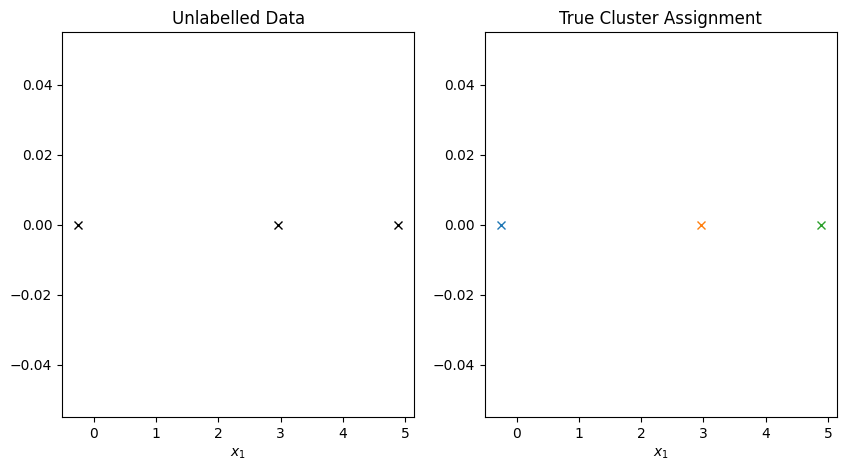

In [5]:
np.random.seed(1)

N_points = 3

## probability p(c)
p = [0.33,0.33,0.34]
c = [0,1,2]

## probability p(x|c)
var1 = 0.1
var2 = 0.01
var3 = 0.01
p_xc = {
    'c_0' : {
        'mu' : np.array([0]),
        'cov' : var1*np.eye(1),
        },
    'c_1' : {
        'mu' : np.array([3]),
        'cov' : var2*np.eye(1),
        },
    'c_2' : {
        'mu' : np.array([5]),
        'cov' : var3*np.eye(1),
        }   
}

## sample cluster assignments
cluster = np.random.choice(c, size=N_points, p=p)

## 
X = np.zeros((N_points,1), dtype = np.float32)
counter = 0
X_clust = {}
for _c in c:
    num_c = np.sum(cluster==_c)
    
    mu  = p_xc[f'c_{_c}']['mu']
    cov = p_xc[f'c_{_c}']['cov']
    
    _x = np.random.multivariate_normal(mean=mu, cov=cov, size = num_c)
    
    X[counter:counter + num_c] = _x
    X_clust[_c] = _x
    
    counter += num_c

fig, (ax1,ax2) = plt.subplots(1,2, figsize = (10,5))
ax1.plot(X[:,0],np.zeros_like(X), 'x', color = 'k')
ax1.set_xlabel(r"$x_1$")
ax1.set_title("Unlabelled Data")

for _c in c:
    _x = X_clust[_c]
    ax2.plot(_x[:,0],np.zeros_like(_x), 'x', color = f"C{_c}")
    ax2.set_xlabel(r"$x_1$")
    ax2.set_title("True Cluster Assignment")


## shuffle data
for i in range(10):
    np.random.shuffle(X)

**Task:** Get two initial centroids. You can do it by selecting randomly from these 3 points or just get you kmeans implementation and call the method initialize_centroids. You can use as many centroids as you want. Start with two and then we will see other options.

In [6]:
interactive_plot = False

if interactive_plot:
    %matplotlib tk
    plt.close("all")
else:
    %matplotlib inline
    
plotter = None

kmeans = Kmeans(num_centroids = 2)
kmeans.initialize_centroids(X, seed = 1)

print("==================")
print("Selected centroids")
print(kmeans.centroids)

Selected centroids
[[2.9551122]
 [4.8894067]]


**Task:** Draw the loss function by fixing one centroid to a value and iterate over other values for the other centroid, compute the loss and display. Do not focus on displaying colors within the different regions. One you have the code try to do it. The idea is to assign a color to each region, defined by having the same cluster assignments.

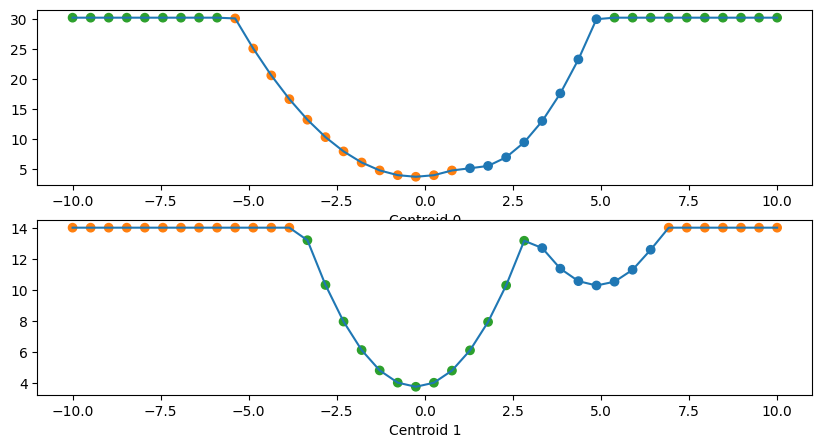

In [7]:
# Plotting specifications
N_grid = 40
grid_lim_l = -10
grid_lim_u = 10
c_coord_range = np.reshape(np.linspace(grid_lim_l,grid_lim_u,N_grid),(N_grid,1))
vor_grid_xx = np.reshape( np.linspace(grid_lim_l, grid_lim_u, 500), (500,1))

fig_1, ax_list_1 = plt.subplots(kmeans.num_centroids,1, figsize = (10,5))

## Locally convex vs wthing assginment change
locally_convex = False
true_centroids_assigned, true_X_assigned = assign_data_to_centroids(X, centroids = kmeans.centroids)

## ====================
## Parameter to vary ##
## Centroid and coordinate

## to separate the cost function within the different assignments
assigned_regions = {}

# to keep loss
loss_acc = {}

# to keep region colors
region_colors = {}

for cent2change in range(kmeans.num_centroids):
    
    ## to separate the cost function within the different assignments
    assigned_regions[cent2change] = []

    # Get initial centroids
    centroids = copy.deepcopy(kmeans.centroids)

    # to keep loss
    loss_acc[cent2change] = []
    
    for _c in c_coord_range:
        centroids[cent2change,:] = _c

        if locally_convex:
            centroids_assigned, X_assigned = true_centroids_assigned, true_X_assigned 
        else:
            centroids_assigned, X_assigned = assign_data_to_centroids(X, centroids = centroids)

        assigned_regions[cent2change].append(tuple(centroids_assigned))

        loss = kmeans_loss_function(X, centroids = centroids, X_assigned = X_assigned)
        loss_acc[cent2change].append(loss)
 
    unique_assignments = list(set(assigned_regions[cent2change]))
    region_colors[cent2change] = [f"C{unique_assignments.index(a)}" for a in assigned_regions[cent2change]]
   
    ## ==================
    ## Draw loss function
    ax_list_1[cent2change].plot(c_coord_range, loss_acc[cent2change], c = 'C0')
    ax_list_1[cent2change].scatter(c_coord_range, loss_acc[cent2change], c = region_colors[cent2change])

    ax_list_1[cent2change].set_xlabel(f"Centroid {cent2change}")
    

**Task:** Draw loss function changing the number of points created to 8.

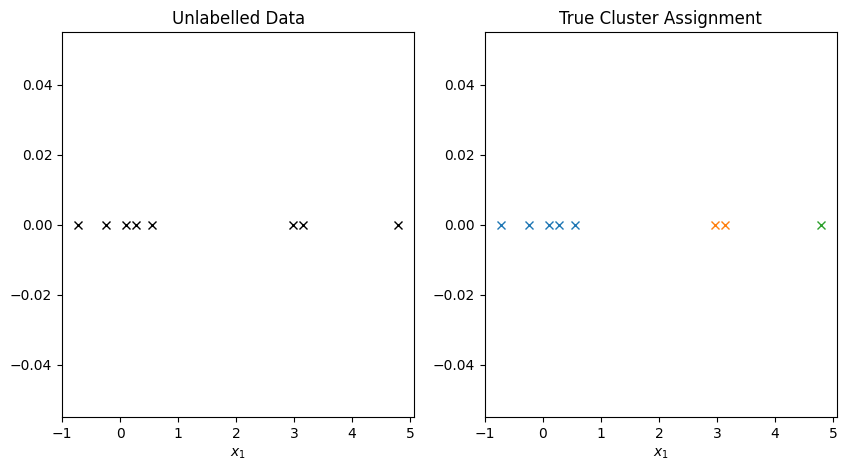

In [8]:
np.random.seed(1)

N_points = 8

## probability p(c)
p = [0.33,0.33,0.34]
c = [0,1,2]

## probability p(x|c)
var1 = 0.1
var2 = 0.01
var3 = 0.01
p_xc = {
    'c_0' : {
        'mu' : np.array([0]),
        'cov' : var1*np.eye(1),
        },
    'c_1' : {
        'mu' : np.array([3]),
        'cov' : var2*np.eye(1),
        },
    'c_2' : {
        'mu' : np.array([5]),
        'cov' : var3*np.eye(1),
        }   
}

## sample cluster assignments
cluster = np.random.choice(c, size=N_points, p=p)

## 
X = np.zeros((N_points,1), dtype = np.float32)
counter = 0
X_clust = {}
for _c in c:
    num_c = np.sum(cluster==_c)
    
    mu  = p_xc[f'c_{_c}']['mu']
    cov = p_xc[f'c_{_c}']['cov']
    
    _x = np.random.multivariate_normal(mean=mu, cov=cov, size = num_c)
    
    X[counter:counter + num_c] = _x
    X_clust[_c] = _x
    
    counter += num_c

fig, (ax1,ax2) = plt.subplots(1,2, figsize = (10,5))
ax1.plot(X[:,0],np.zeros_like(X), 'x', color = 'k')
ax1.set_xlabel(r"$x_1$")
ax1.set_title("Unlabelled Data")

for _c in c:
    _x = X_clust[_c]
    ax2.plot(_x[:,0],np.zeros_like(_x), 'x', color = f"C{_c}")
    ax2.set_xlabel(r"$x_1$")
    ax2.set_title("True Cluster Assignment")


## shuffle data
for i in range(10):
    np.random.shuffle(X)

In [9]:
interactive_plot = False

if interactive_plot:
    %matplotlib tk
    plt.close("all")
else:
    %matplotlib inline
    
plotter = None

kmeans = Kmeans(num_centroids = 2)
kmeans.initialize_centroids(X, seed = 1)

print("==================")
print("Selected centroids")
print(kmeans.centroids)

Selected centroids
[[ 4.793986  ]
 [-0.24071476]]


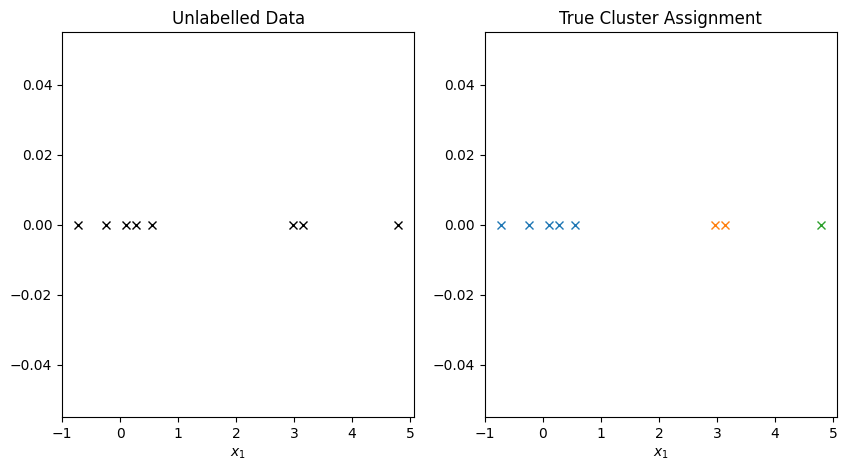

In [10]:
np.random.seed(1)

N_points = 8

## probability p(c)
p = [0.33,0.33,0.34]
c = [0,1,2]

## probability p(x|c)
var1 = 0.1
var2 = 0.01
var3 = 0.01
p_xc = {
    'c_0' : {
        'mu' : np.array([0]),
        'cov' : var1*np.eye(1),
        },
    'c_1' : {
        'mu' : np.array([3]),
        'cov' : var2*np.eye(1),
        },
    'c_2' : {
        'mu' : np.array([5]),
        'cov' : var3*np.eye(1),
        }   
}

## sample cluster assignments
cluster = np.random.choice(c, size=N_points, p=p)

## 
X = np.zeros((N_points,1), dtype = np.float32)
counter = 0
X_clust = {}
for _c in c:
    num_c = np.sum(cluster==_c)
    
    mu  = p_xc[f'c_{_c}']['mu']
    cov = p_xc[f'c_{_c}']['cov']
    
    _x = np.random.multivariate_normal(mean=mu, cov=cov, size = num_c)
    
    X[counter:counter + num_c] = _x
    X_clust[_c] = _x
    
    counter += num_c

fig, (ax1,ax2) = plt.subplots(1,2, figsize = (10,5))
ax1.plot(X[:,0],np.zeros_like(X), 'x', color = 'k')
ax1.set_xlabel(r"$x_1$")
ax1.set_title("Unlabelled Data")

for _c in c:
    _x = X_clust[_c]
    ax2.plot(_x[:,0],np.zeros_like(_x), 'x', color = f"C{_c}")
    ax2.set_xlabel(r"$x_1$")
    ax2.set_title("True Cluster Assignment")


## shuffle data
for i in range(10):
    np.random.shuffle(X)

In [11]:
interactive_plot = False

if interactive_plot:
    %matplotlib tk
    plt.close("all")
else:
    %matplotlib inline
    
plotter = None

kmeans = Kmeans(num_centroids = 2)
kmeans.initialize_centroids(X, seed = 1)

print("==================")
print("Selected centroids")
print(kmeans.centroids)

Selected centroids
[[ 4.793986  ]
 [-0.24071476]]


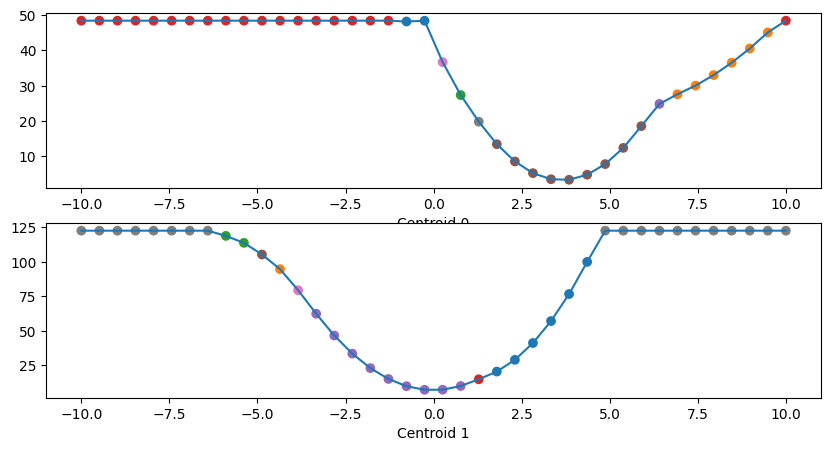

In [12]:
# Plotting specifications
N_grid = 40
grid_lim_l = -10
grid_lim_u = 10
c_coord_range = np.reshape(np.linspace(grid_lim_l,grid_lim_u,N_grid),(N_grid,1))
vor_grid_xx = np.reshape( np.linspace(grid_lim_l, grid_lim_u, 500), (500,1))

fig_1, ax_list_1 = plt.subplots(kmeans.num_centroids,1, figsize = (10,5))

## Locally convex vs wthing assginment change
locally_convex = False
true_centroids_assigned, true_X_assigned = assign_data_to_centroids(X, centroids = kmeans.centroids)

## ====================
## Parameter to vary ##
## Centroid and coordinate

## to separate the cost function within the different assignments
assigned_regions = {}

# to keep loss
loss_acc = {}

# to keep region colors
region_colors = {}

for cent2change in range(kmeans.num_centroids):
    
    ## to separate the cost function within the different assignments
    assigned_regions[cent2change] = []

    # Get initial centroids
    centroids = copy.deepcopy(kmeans.centroids)

    # to keep loss
    loss_acc[cent2change] = []
    
    for _c in c_coord_range:
        centroids[cent2change,:] = _c

        if locally_convex:
            centroids_assigned, X_assigned = true_centroids_assigned, true_X_assigned 
        else:
            centroids_assigned, X_assigned = assign_data_to_centroids(X, centroids = centroids)

        assigned_regions[cent2change].append(tuple(centroids_assigned))

        loss = kmeans_loss_function(X, centroids = centroids, X_assigned = X_assigned)
        loss_acc[cent2change].append(loss)
 
    unique_assignments = list(set(assigned_regions[cent2change]))
    region_colors[cent2change] = [f"C{unique_assignments.index(a)}" for a in assigned_regions[cent2change]]
   
    ## ==================
    ## Draw loss function
    ax_list_1[cent2change].plot(c_coord_range, loss_acc[cent2change], c = 'C0')
    ax_list_1[cent2change].scatter(c_coord_range, loss_acc[cent2change], c = region_colors[cent2change])

    ax_list_1[cent2change].set_xlabel(f"Centroid {cent2change}")
    

**Task:** Now vary the number of centroids and see different loss functions.

In [13]:
interactive_plot = False

if interactive_plot:
    %matplotlib tk
    plt.close("all")
else:
    %matplotlib inline
    
plotter = None

kmeans = Kmeans(num_centroids = 5)
kmeans.initialize_centroids(X, seed = 1)

print("==================")
print("Selected centroids")
print(kmeans.centroids)

Selected centroids
[[ 4.793986  ]
 [-0.24071476]
 [-0.72781044]
 [ 0.55175793]
 [ 0.10088902]]


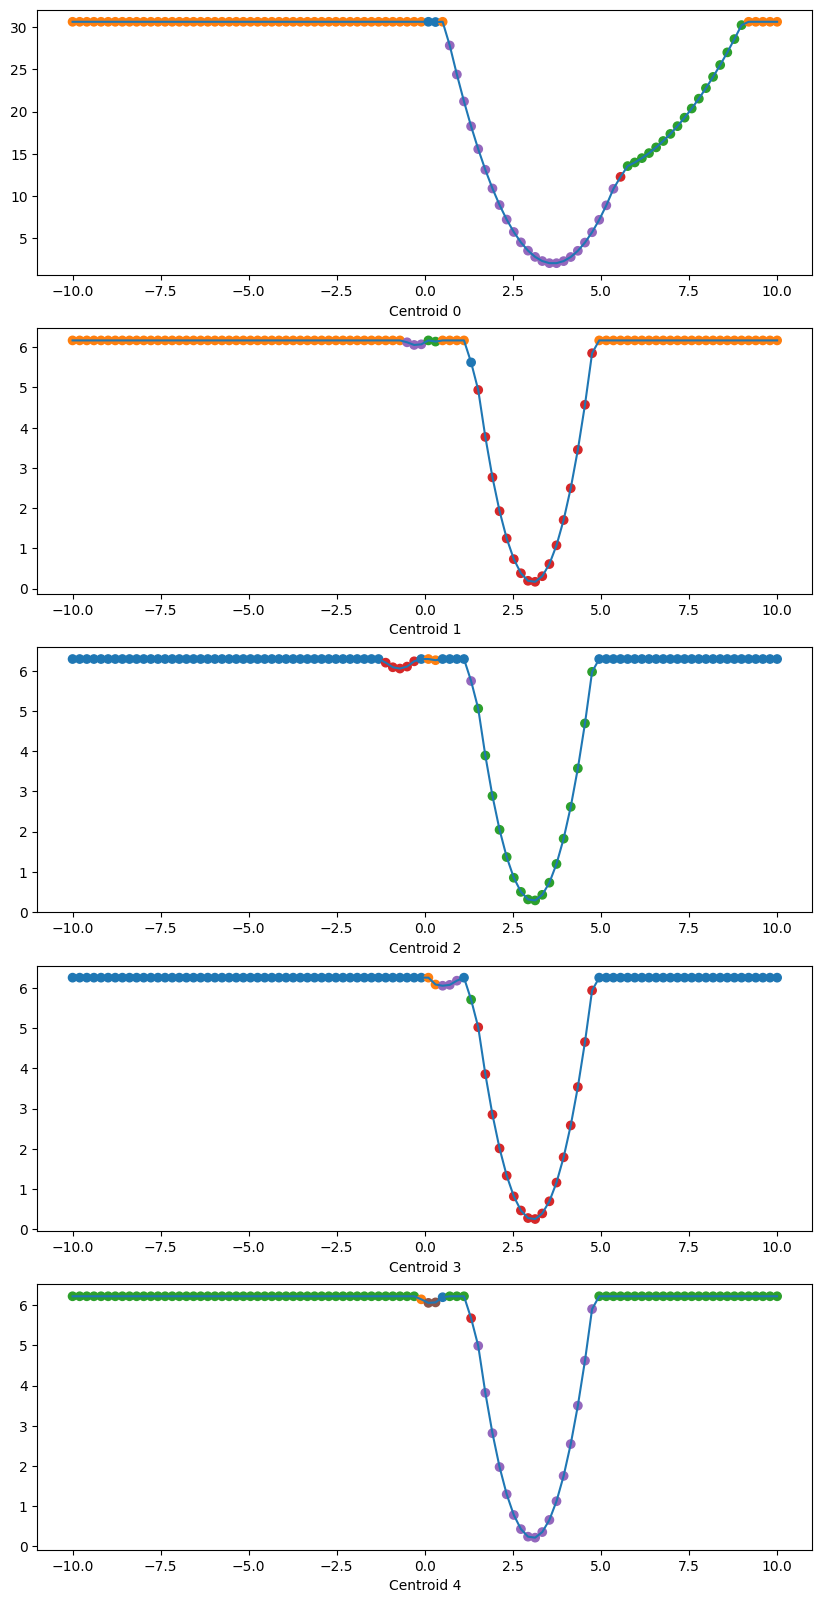

In [14]:
# Plotting specifications
N_grid = 100
grid_lim_l = -10
grid_lim_u = 10
c_coord_range = np.reshape(np.linspace(grid_lim_l,grid_lim_u,N_grid),(N_grid,1))
vor_grid_xx = np.reshape( np.linspace(grid_lim_l, grid_lim_u, 500), (500,1))

fig_1, ax_list_1 = plt.subplots(kmeans.num_centroids,1, figsize = (10,20))

## Locally convex vs wthing assginment change
locally_convex = False
true_centroids_assigned, true_X_assigned = assign_data_to_centroids(X, centroids = kmeans.centroids)

## ====================
## Parameter to vary ##
## Centroid and coordinate

## to separate the cost function within the different assignments
assigned_regions = {}

# to keep loss
loss_acc = {}

# to keep region colors
region_colors = {}

for cent2change in range(kmeans.num_centroids):
    
    ## to separate the cost function within the different assignments
    assigned_regions[cent2change] = []

    # Get initial centroids
    centroids = copy.deepcopy(kmeans.centroids)

    # to keep loss
    loss_acc[cent2change] = []
    
    for _c in c_coord_range:
        centroids[cent2change,:] = _c

        if locally_convex:
            centroids_assigned, X_assigned = true_centroids_assigned, true_X_assigned 
        else:
            centroids_assigned, X_assigned = assign_data_to_centroids(X, centroids = centroids)

        assigned_regions[cent2change].append(tuple(centroids_assigned))

        loss = kmeans_loss_function(X, centroids = centroids, X_assigned = X_assigned)
        loss_acc[cent2change].append(loss)
 
    unique_assignments = list(set(assigned_regions[cent2change]))
    region_colors[cent2change] = [f"C{unique_assignments.index(a)}" for a in assigned_regions[cent2change]]
   
    ## ==================
    ## Draw loss function
    ax_list_1[cent2change].plot(c_coord_range, loss_acc[cent2change], c = 'C0')
    ax_list_1[cent2change].scatter(c_coord_range, loss_acc[cent2change], c = region_colors[cent2change])

    ax_list_1[cent2change].set_xlabel(f"Centroid {cent2change}")

**Task:** Given a cluster assignment, all the loss functions are convex. Modify your previous code so that the loss function is computed always with the same assignment, to see this convexity.

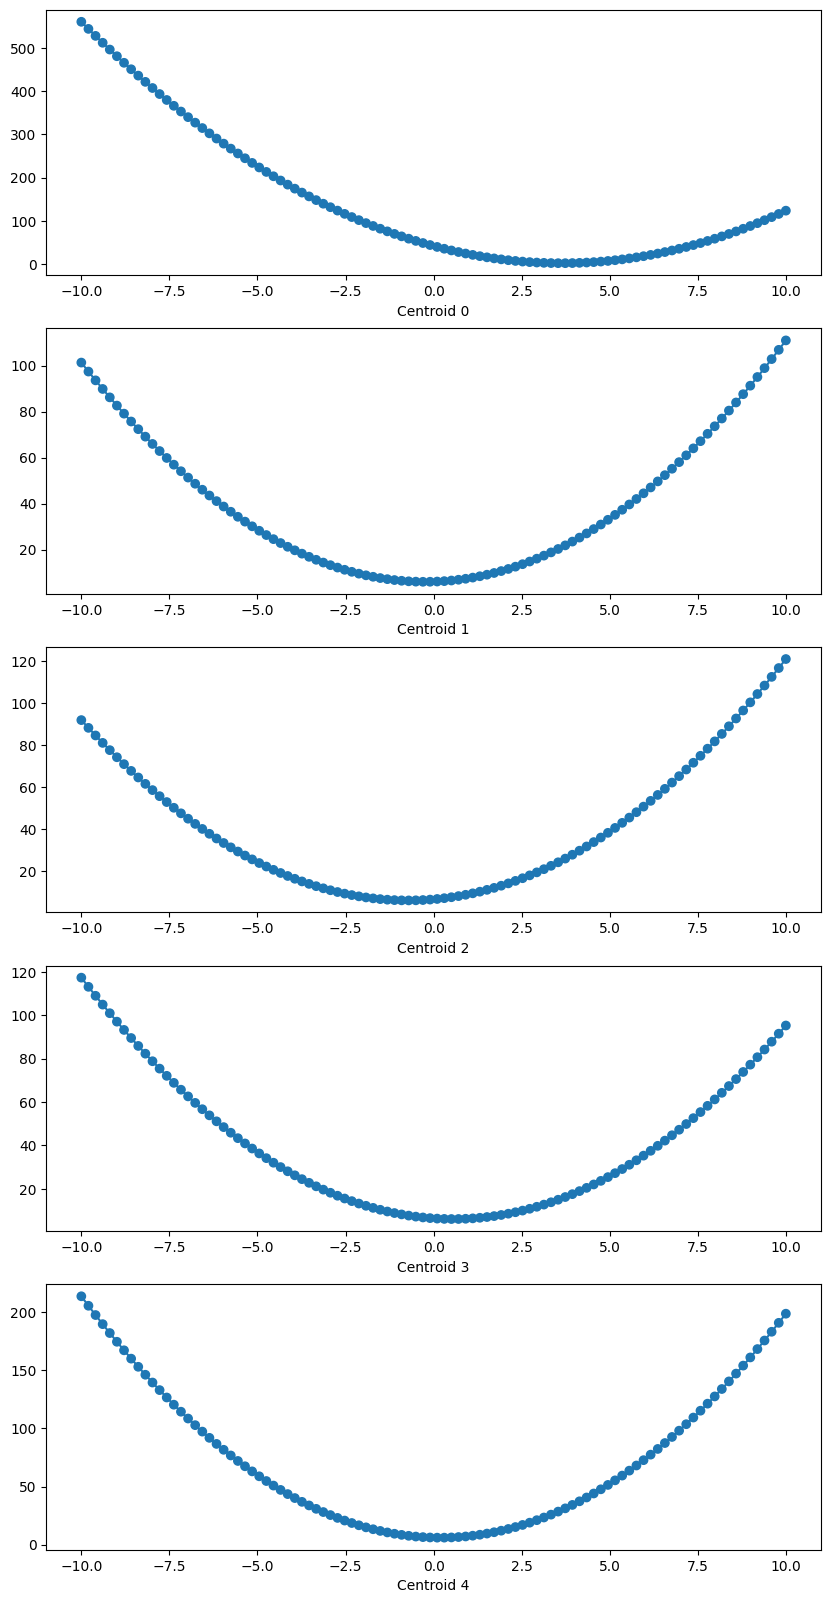

In [15]:
# Plotting specifications
N_grid = 100
grid_lim_l = -10
grid_lim_u = 10
c_coord_range = np.reshape(np.linspace(grid_lim_l,grid_lim_u,N_grid),(N_grid,1))
vor_grid_xx = np.reshape( np.linspace(grid_lim_l, grid_lim_u, 500), (500,1))

fig_1, ax_list_1 = plt.subplots(kmeans.num_centroids,1, figsize = (10,20))

## Locally convex vs wthing assginment change
locally_convex = True
true_centroids_assigned, true_X_assigned = assign_data_to_centroids(X, centroids = kmeans.centroids)

## ====================
## Parameter to vary ##
## Centroid and coordinate

## to separate the cost function within the different assignments
assigned_regions = {}

# to keep loss
loss_acc = {}

# to keep region colors
region_colors = {}

for cent2change in range(kmeans.num_centroids):
    
    ## to separate the cost function within the different assignments
    assigned_regions[cent2change] = []

    # Get initial centroids
    centroids = copy.deepcopy(kmeans.centroids)

    # to keep loss
    loss_acc[cent2change] = []
    
    for _c in c_coord_range:
        centroids[cent2change,:] = _c

        if locally_convex:
            centroids_assigned, X_assigned = true_centroids_assigned, true_X_assigned 
        else:
            centroids_assigned, X_assigned = assign_data_to_centroids(X, centroids = centroids)

        assigned_regions[cent2change].append(tuple(centroids_assigned))

        loss = kmeans_loss_function(X, centroids = centroids, X_assigned = X_assigned)
        loss_acc[cent2change].append(loss)
 
    unique_assignments = list(set(assigned_regions[cent2change]))
    region_colors[cent2change] = [f"C{unique_assignments.index(a)}" for a in assigned_regions[cent2change]]
   
    ## ==================
    ## Draw loss function
    ax_list_1[cent2change].plot(c_coord_range, loss_acc[cent2change], c = 'C0')
    ax_list_1[cent2change].scatter(c_coord_range, loss_acc[cent2change], c = region_colors[cent2change])

    ax_list_1[cent2change].set_xlabel(f"Centroid {cent2change}")